# Computational Graphs &mdash; A Demo Application

In [1]:
import math
import torch

import pandas as pd

In [2]:
dtype = torch.float

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)
if device.type == 'cuda':
    print('Current device name:', torch.cuda.get_device_name())
    print('CUDA device count:', torch.cuda.device_count())

Current device: cpu


In [3]:
# Some parts are based on 
# https://stackoverflow.com/questions/75610911/how-to-use-mermaid-diagram-in-jupyter-notebook-with-mermaid-ink-through-proxy

import base64
from IPython.display import Image, display

def mermaid(graph: str):
    graph_bytes = graph.encode("ascii")
    base64_bytes = base64.b64encode(graph_bytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

In [4]:
# For saving results in the future in order to visualize

results = {}
for name in ('a', 'b', 'c'):
    results[name] = []

def save_result(a: torch.Tensor, b: torch.Tensor, c: torch.Tensor):
    results['a'].append(a.item())
    results['b'].append(b.item())
    results['c'].append(c.item())

We will fit $y = \sin x$, where $x \in [0, \pi / 2]$, with the quadratic polynomial $y = a + bx + cx^2$. There will be three parameters $a$, $b$, $c$ trained with gradient descent.

In [5]:
# Create input and output data
x = torch.linspace(0, math.pi / 2, 2000, \
                   dtype=dtype, device=device)
x_indices = torch.randperm(2000, device=device)
x = x[x_indices].reshape(-1, 1)

y = torch.sin(x)

### Computational Graph

#### From scratch (Batch Gradient Descent)

Let $a$, $b$, $c$ are weights as scalars; <br/>
$\textrm{x}$ is a vector of a finite number of values of $x \in [0, \pi / 2]$; <br/>
$\textrm{y}$, $\textrm{t}$, $\textrm{j}$ are vectors that have the same size as $\textrm{x}$, <br/>
and $y_i = \sin x_i,\; t_i = x_i^2,\; j_i = 1$ (Each of $y_i$, $t_i$, $j_i$ is the $i$-th element of $\textrm{y}$, $\textrm{t}$, $\textrm{j}$, respectively), we have

$$\textrm{y}_{pred} = a\;\textrm{j} + b\;\textrm{x} + c\;\textrm{t}\;, \quad 
J = (\textrm{y}_{pred} - \textrm{y})^\top (\textrm{y}_{pred} - \textrm{y})$$

and
$$\frac{\partial{J}}{\partial{\textrm{y}_{pred}}} = 2 (\textrm{y}_{pred} - \textrm{y})^\top\;, \quad
\frac{\partial{\textrm{y}_{pred}}}{\partial{a}} = \textrm{j}\;, \quad 
\frac{\partial{\textrm{y}_{pred}}}{\partial{b}} = \textrm{x}\;, \quad 
\frac{\partial{\textrm{y}_{pred}}}{\partial{c}} = \textrm{t}\;.$$

In [6]:
# To draw the diagram, Internet connection is required
mermaid("""graph TD;
    x --> t;
    x --> y_pred;
    t --> y_pred;
    a --> y_pred;
    b --> y_pred;
    c --> y_pred;
    y_pred --> J;
    y --> J;
""")

In [7]:
t = x * x
j = torch.ones(x.shape)

# Initialize weights
a = torch.randn((), dtype=dtype, device=device)
b = torch.randn((), dtype=dtype, device=device)
c = torch.randn((), dtype=dtype, device=device)

learning_rate = 1e-4
for iter in range(2000):
    
    # Forward pass: compute predicted y and loss J
    y_pred = a * j + b * x + c * t
    loss = (y_pred - y).T.mm(y_pred - y)

    # Backprop to compute gradients of a, b, c with respect to loss J
    grad_y_pred = 2 * (y_pred - y).T
    grad_a = grad_y_pred.mm(j).item()
    grad_b = grad_y_pred.mm(x).item()
    grad_c = grad_y_pred.mm(t).item()

    # Update weights
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c

    # Print loss
    if iter % 100 == 99:
        print(f'Iter. {iter}: loss = {round(loss.item(), 4)}')

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2')

# Save result
save_result(a, b, c)

Iter. 99: loss = 13.9879
Iter. 199: loss = 6.9231
Iter. 299: loss = 3.4628
Iter. 399: loss = 1.768
Iter. 499: loss = 0.9378
Iter. 599: loss = 0.5313
Iter. 699: loss = 0.3321
Iter. 799: loss = 0.2346
Iter. 899: loss = 0.1868
Iter. 999: loss = 0.1634
Iter. 1099: loss = 0.1519
Iter. 1199: loss = 0.1463
Iter. 1299: loss = 0.1436
Iter. 1399: loss = 0.1422
Iter. 1499: loss = 0.1416
Iter. 1599: loss = 0.1412
Iter. 1699: loss = 0.1411
Iter. 1799: loss = 0.141
Iter. 1899: loss = 0.141
Iter. 1999: loss = 0.1409
Result: y = -0.02404254674911499 + 1.1948506832122803 x + -0.33772528171539307 x^2


#### Using `torch` (Stochastic Gradient Descent)

In [8]:
# Initialize weights
a = torch.randn((), dtype=dtype, device=device, requires_grad=True)
b = torch.randn((), dtype=dtype, device=device, requires_grad=True)
c = torch.randn((), dtype=dtype, device=device, requires_grad=True)

# Initialize optimizer
optimizer = torch.optim.SGD([a, b, c], lr=1e-3)

for iter in range(150):

    for input, target in zip(x, y):
        # Set gradients to zero
        optimizer.zero_grad()

        # Forward pass: Compute the predicted y and loss J
        y_pred = a + b * input + c * input ** 2
        loss = (y_pred - target) ** 2

        # Backprop to compute gradients of a, b, c with respect to loss
        loss.backward()

        # Optimizer does its job
        optimizer.step()
        
    # Print loss
    if iter % 10 == 9:
        print(f'Iter. {iter}: loss = {loss.item()}')

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2')

# Save result
save_result(a, b, c)

Iter. 9: loss = 0.016616875305771828
Iter. 19: loss = 0.007549468893557787
Iter. 29: loss = 0.0033027788158506155
Iter. 39: loss = 0.0013597712386399508
Iter. 49: loss = 0.000504327064845711
Iter. 59: loss = 0.0001528342254459858
Iter. 69: loss = 2.805431722663343e-05
Iter. 79: loss = 1.2220704093124368e-07
Iter. 89: loss = 9.699177098809741e-06
Iter. 99: loss = 3.066723365918733e-05
Iter. 109: loss = 5.2355222578626126e-05
Iter. 119: loss = 7.096162153175101e-05
Iter. 129: loss = 8.564756717532873e-05
Iter. 139: loss = 9.677260823082179e-05
Iter. 149: loss = 0.00010498863412067294
Result: y = -0.02293064258992672 + 1.1913050413131714 x + -0.3357333838939667 x^2


### Without Any Computational Graph (Batch Gradient Descent)

$$y_{pred} = a + bx + cx^2\;, \quad J = \sum_{x} {(y_{pred} - y)^2}$$
$$\frac{\partial{J}}{\partial{a}} = 2 \sum_{x} (y_{pred} - y)\;, \quad 
\frac{\partial{J}}{\partial{b}} = 2 \sum_{x} (y_{pred} - y)x\;, \quad 
\frac{\partial{J}}{\partial{c}} = 2 \sum_{x} (y_{pred} - y)x^2$$

In [9]:
# Some parts are based on https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# Initialize weights
a = torch.randn((), dtype=dtype, device=device)
b = torch.randn((), dtype=dtype, device=device)
c = torch.randn((), dtype=dtype, device=device)

learning_rate = 1e-4
for iter in range(2000):    
    
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if iter % 100 == 99:
        print(f'Iter. {iter}: loss = {round(loss, 4)}')
    
    # Backpropagation to compute gradients of a, b, c with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()

    # Update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2')

# Save result
save_result(a, b, c)

Iter. 99: loss = 0.1452
Iter. 199: loss = 0.143
Iter. 299: loss = 0.142
Iter. 399: loss = 0.1414
Iter. 499: loss = 0.1412
Iter. 599: loss = 0.141
Iter. 699: loss = 0.141
Iter. 799: loss = 0.141
Iter. 899: loss = 0.1409
Iter. 999: loss = 0.1409
Iter. 1099: loss = 0.1409
Iter. 1199: loss = 0.1409
Iter. 1299: loss = 0.1409
Iter. 1399: loss = 0.1409
Iter. 1499: loss = 0.1409
Iter. 1599: loss = 0.1409
Iter. 1699: loss = 0.1409
Iter. 1799: loss = 0.1409
Iter. 1899: loss = 0.1409
Iter. 1999: loss = 0.1409
Result: y = -0.024280566722154617 + 1.1956654787063599 x + -0.3382163643836975 x^2


### Visualization

          x         y  Pred. y (CG - BGD)  Pred. y (CG - SGD)  Pred. y (BGD)
0  0.436114  0.422420            0.432815            0.432759       0.432839
1  0.220807  0.219017            0.223323            0.223749       0.223241
2  0.360678  0.352909            0.362980            0.363072       0.362972
3  1.246265  0.947800            0.940511            0.940298       0.940526
4  1.371991  0.980303            0.979562            0.979558       0.979517


<Axes: xlabel='x', ylabel='y'>

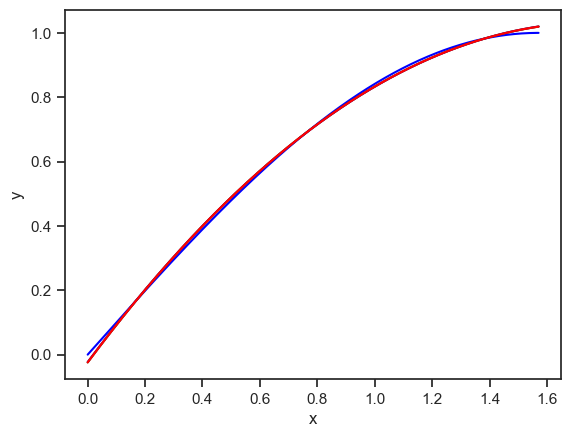

In [10]:
import seaborn as sns
sns.set_theme(style='ticks')

def model(a, b, c, input):
    return a + b * input + c * input ** 2

x = x.reshape(-1)
y = x.sin()
df = torch.stack((
    x,
    y,
    model(results['a'][0], results['b'][0], results['c'][0], x),
    model(results['a'][1], results['b'][1], results['c'][1], x),
    model(results['a'][2], results['b'][2], results['c'][2], x)
)).t().numpy()
df = pd.DataFrame(df, columns=['x', 'y', 
                               'Pred. y (CG - BGD)', 'Pred. y (CG - SGD)', 'Pred. y (BGD)'])

print(df.head())

sns.lineplot(data=df, x='x', y='y', color='blue')
sns.lineplot(data=df, x='x', y='Pred. y (CG - BGD)', color='green')
sns.lineplot(data=df, x='x', y='Pred. y (CG - SGD)', color='purple')
sns.lineplot(data=df, x='x', y='Pred. y (BGD)', color='red')

In the plot above,
- The blue curve: Actual values of $\sin x$
- The green curve: Predicted y using Computational Graph (Batch Gradient Descent)
- The purple curve: Predicted y using Computational Graph (Stochastic Gradient Descent)
- The red curve: Predicted y using Batch Gradient Descent only

We can see that the last three curves are almost the same and we just see the red curve.

          x         y  Pred. y (CG - BGD)  Pred. y (CG - SGD)  Pred. y (BGD)
0  1.000312  0.841640            0.833245            0.832803       0.833331
1  1.005027  0.844176            0.835685            0.835246       0.835770
2  1.008956  0.846276            0.837707            0.837270       0.837792
3  1.007384  0.845438            0.836900            0.836461       0.836984
4  1.001884  0.842487            0.834060            0.833619       0.834145


<Axes: xlabel='x', ylabel='y'>

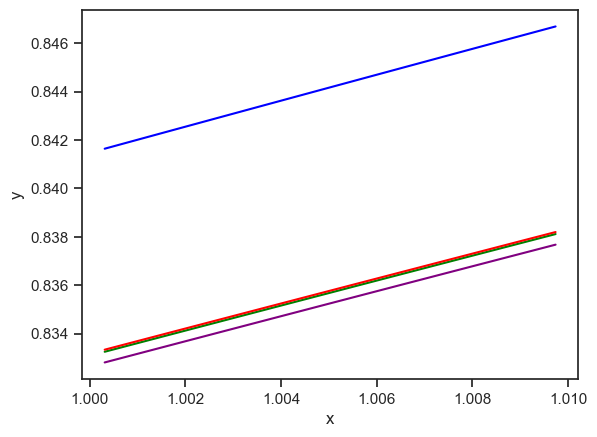

In [11]:
mask = (x > 1.0) & (x < 1.01)
x_zoom = x[mask]

df = torch.stack((
    x_zoom,
    x_zoom.sin(),
    model(results['a'][0], results['b'][0], results['c'][0], x_zoom),
    model(results['a'][1], results['b'][1], results['c'][1], x_zoom),
    model(results['a'][2], results['b'][2], results['c'][2], x_zoom)
)).t().numpy()
df = pd.DataFrame(df, columns=['x', 'y', 
                               'Pred. y (CG - BGD)', 'Pred. y (CG - SGD)', 'Pred. y (BGD)'])

print(df.head())

sns.lineplot(data=df, x='x', y='y', color='blue')
sns.lineplot(data=df, x='x', y='Pred. y (CG - BGD)', color='green')
sns.lineplot(data=df, x='x', y='Pred. y (CG - SGD)', color='purple')
sns.lineplot(data=df, x='x', y='Pred. y (BGD)', color='red')

With $x \in (1.0, 1.01)$, we can see the difference between them more clearly.